__Bayesian Regularization__

So, we've seen that we can use an inversion to reconstruct an image. Furthermore, this reconstruction provides us with the 'best-fit' solution. And, indeed, when we inspect the fit with the fitting module, we see residuals indicative of a good fit.

Everything sounds pretty good, doesn't it? You're probably thinking, why are there more tutorials? We can use inversions now, don't ruin it! Well, there is a problem - which I hid from you in the last tutorial, which we'll cover now.

In [ ]:
%matplotlib inline

from autolens.data import ccd
from autolens.data.array import mask as msk
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import ray_tracing
from autolens.lens import lens_fit
from autolens.lens import lens_data as ld
from autolens.model.inversion import pixelizations as pix
from autolens.model.inversion import regularization as reg
from autolens.lens.plotters import lens_fit_plotters
from autolens.model.inversion.plotters import inversion_plotters

Lets use the same simple source as last time.

In [2]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(180, 180), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                        einstein_radius=1.6))
    source_galaxy_0 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=90.0, intensity=0.2,
                                                         effective_radius=0.3, sersic_index=1.0))

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy],
                                                 source_galaxies=[source_galaxy_0],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    return ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

We're going to perform a lot of fits using an inversion this tutorial. This would create a lot of code, so to keep things tidy, I've setup this function which handles it all for us.

(You may notice we include a border in the tracer, instead of setting it to None - just ignore this for now, as we'll be covering borders in the next tutorial).

In [3]:
def perform_fit_with_source_galaxy(source_galaxy):

    ccd_data = simulate()
    mask = msk.Mask.circular_annular(shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, 
                                     inner_radius_arcsec=0.5, outer_radius_arcsec=2.2)
    lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)
    lens_galaxy = g.Galaxy(
        mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grid_stack=lens_data.grid_stack, border=lens_data.border)
    return lens_fit.fit_lens_data_with_tracer(lens_data=lens_data, tracer=tracer)

Okay, so lets look at our fit from the previous tutorial in more detail. We'll use a higher resolution 40 x 40 grid.

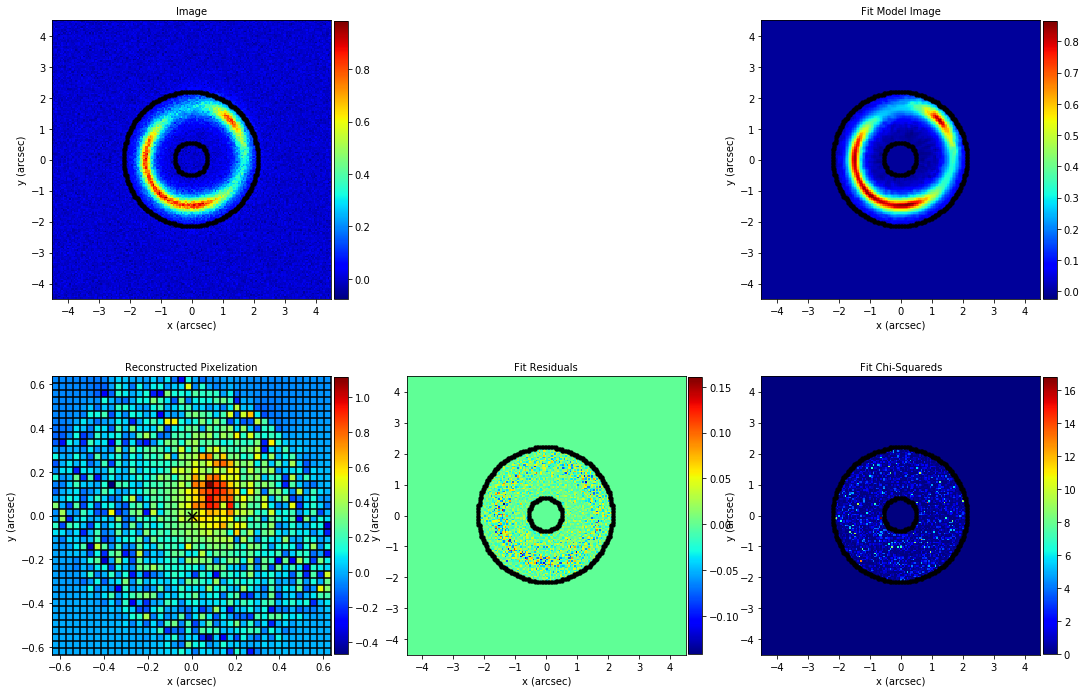

In [4]:
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)), regularization=reg.Constant(coefficients=(1.0,)))
fit = perform_fit_with_source_galaxy(source_galaxy=source_galaxy)
lens_fit_plotters.plot_fit_subplot(fit=fit, should_plot_mask=True, zoom_around_mask=True)

It still looks pretty good! However, this is because I sneakily chose a regularization coefficient that gives a good looking solution, without telling you. If we reduce this regularization coefficient to zero, our source reconstruction goes extremely weird.

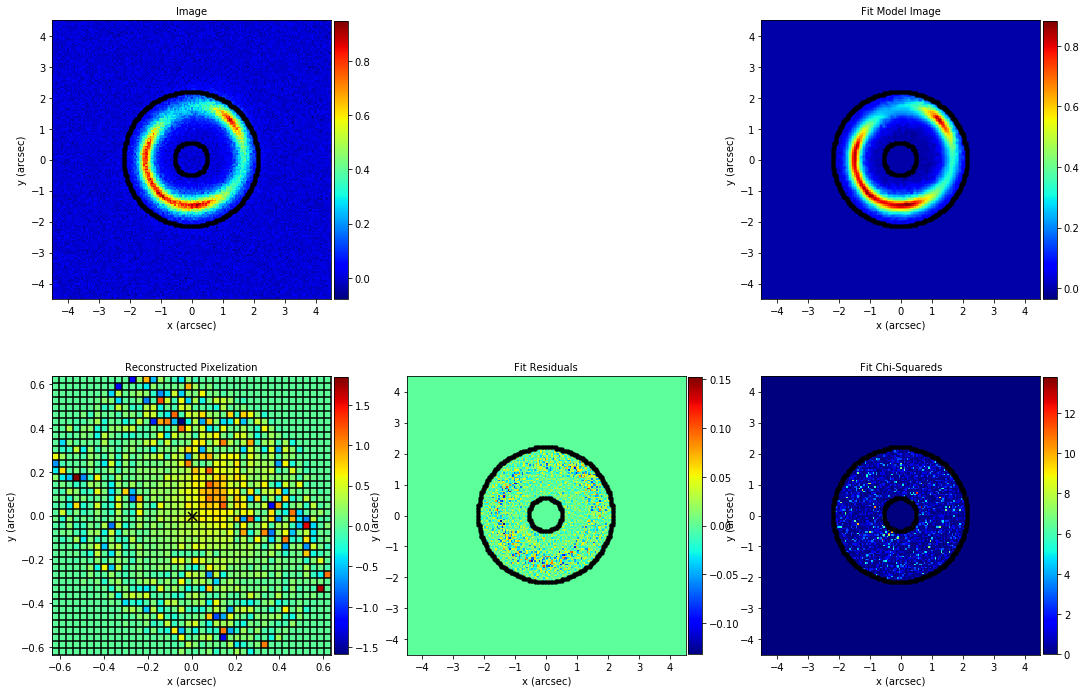

In [5]:
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)), regularization=reg.Constant(coefficients=(0.0,)))
no_regularization_fit = perform_fit_with_source_galaxy(source_galaxy=source_galaxy)
lens_fit_plotters.plot_fit_subplot(fit=no_regularization_fit, should_plot_mask=True, zoom_around_mask=True)

So, what happening here, and why does removing regularization do this to our source reconstruction? When our inversion reconstructs a source, it doesn't *just* compute the set of fluxes that best-fit the image. It is also 'regularized', whereby we go to every pixel on our rectangular grid and compare its reconstructed flux with its neighboring pixels. If the difference in flux is large, we penalize this solution, reducing its likelihood. You can think of this as us 'smoothing' our solution.

This adds a 'penalty term' to the likelihood of an inversion, which is the summed difference between the reconstructed fluxes of every source-pixel pair multiplied by the regularization coefficient. By setting the regularization coefficient to zero, we are thus setting this penalty term to zero, meaning that regularization is omitted.

Why do we need to regularize our solution? Well, we just saw why - if we don't apply this smoothing, we 'over-fit' the image. More specifically, we over-fit the noise in the image - which is what the large flux values located at the exteriors of the source reconstruction are doing. Think about it - if your sole aim is to maximize the likelihood, the best way to do this is to fit *everything* accurately, including the noise.

If we change the 'normalization' variables of the plotter, such that the color-map is restricted to a narrower range of values, we can see that even without regularization we are still reconstructing the actual source galaxy.

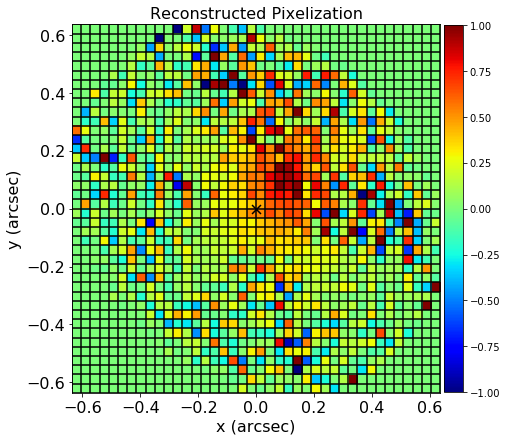

In [7]:
inversion_plotters.plot_reconstructed_pixelization(inversion=no_regularization_fit.inversion,
                                                   norm_max=1.0, norm_min=-1.0)

Over-fitting is why regularization is necessary - solutions like this would completely ruin our attempts to model a strong lens. By smoothing our source reconstruction, we ensure it doesn't fit the noise in the image. If we set a really high regularization coefficient, we can completely remove over-fitting, at the expense of also fitting the image less accurately.

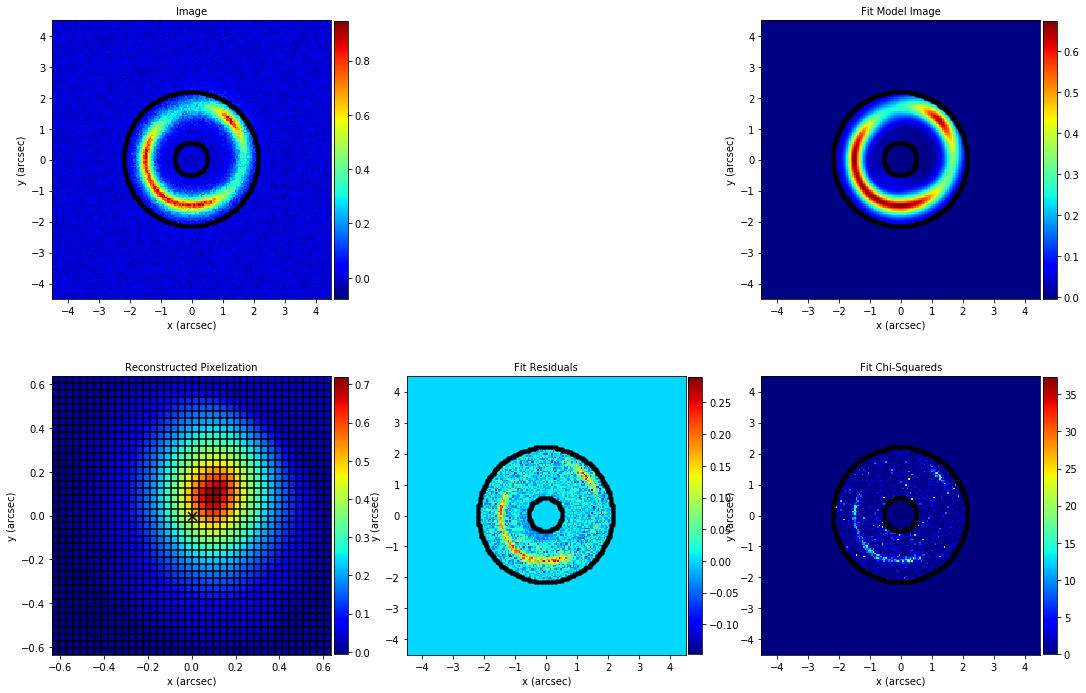

In [8]:
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)),
                         regularization=reg.Constant(coefficients=(100.0,)))
high_regularization_fit = perform_fit_with_source_galaxy(source_galaxy=source_galaxy)
lens_fit_plotters.plot_fit_subplot(fit=high_regularization_fit, should_plot_mask=True, zoom_around_mask=True)

So there we have it, we now understand regularization and its purpose. But there is one nagging question that remains, how do I choose the regularization coefficient? We can't use our likelihood, as decreasing the regularization coefficient will always increase the likelihood, because it allows the source reconstruction to fit the data better.

In [9]:
print('Likelihood Without Regularization:')
print(no_regularization_fit.likelihood_with_regularization)
print('Likelihood With Normal Regularization:')
print(fit.likelihood_with_regularization)
print('Likelihood With High Regularization:')
print(high_regularization_fit.likelihood_with_regularization)


Likelihood Without Regularization:
12947.826617832701
Likelihood With Normal Regularization:
12795.294821983649
Likelihood With High Regularization:
4736.367554230317


If we use the likelihood, we'll always choose a coefficient of 0! We need a different goodness-of-fit measure. For this, we invoke the 'Bayesian evidence', which quantifies the goodness of the fit as follows:

- First, it requires that the residuals of the fit are consistent with Gaussian noise (which is the noise expected in CCD imaging). If this Gaussian pattern is not visible in the residuals, it tells us that the noise must have been over-fitted. Thus, the Bayesian evidence decreases. Obviously, if the image is poorly fitted, the residuals don't appear Gaussian either, but the poor fit will lead to a decrease in Bayesian evidence decreases all the same!

- This leaves us with a large number of solutions which all fit the data equally well (e.g., to the noise level). To determine the best-fit from these solutions, the Bayesian evidence quantifies the complexity of each solution's source reconstruction. If the inversion requires lots of pixels and a low level of regularization to achieve a good fit, the Bayesian evidence decreases. It penalizes solutions which are complex, which, in a Bayesian sense, are less probable (you may want to look up 'Occam's Razor').

If a really complex source reconstruction is paramount to fitting the image accurately, than that is probably the correct solution. However, the Bayesian evidence ensures we only invoke this more complex solution when the data necessitates it.

Lets take a look at the Bayesian evidence:

In [11]:
print('Bayesian Evidence Without Regularization:')
print(no_regularization_fit.evidence)
print('Bayesian Evidence With Normal Regularization:')
print(fit.evidence)
print('Bayesian Evidence With High Regularization:')
print(high_regularization_fit.evidence)

Bayesian Evidence Without Regularization:
-1566.1620236817398
Bayesian Evidence With Normal Regularization:
10390.572846924999
Bayesian Evidence With High Regularization:
4664.5657246481915


Great! As expected, the solution that we could see 'by-eye' was the best solution indeed corresponds to the highest evidence solution.

Before we end, lets consider which aspects of an inversion are linear, and which are non-linear.

The linear part of the linear inversion solves for the 'best-fit' solution. For a given regularizaton coefficient, this includes the regularization pattern. That is, we linearly reconstruct the combination of source-pixel fluxes that best-fit the image *including* the penalty term due to comparing neighboring source-pixel fluxes.
 
However, determining the regularization coefficient that maximizes the Bayesian evidence remains a non-linear problem, and it thus becomes a part of our non-linear search. The Bayesian evidence also depends on the source resolution, which means the pixel-grid resolution may also be part of our non-linear search. Nevertheless, this is only 3 parameters - there were 30+ when using light profiles to represent the source!

Here are a few questions for you to think about.

1) We maximize the evidence by using simpler source reconstructions. Therefore, decreasing the pixel-grid size should provide a higher evidence, provided it still has enough resolution to fit the image well (and provided that the regularization coefficient is still an appropriate value). Can you increase the evidence from the value above by changing these parameters - I've set you up with a code to do so below.

Previous Bayesian Evidence:
10395.370224426646
New Bayesian Evidence:
10406.35482050792


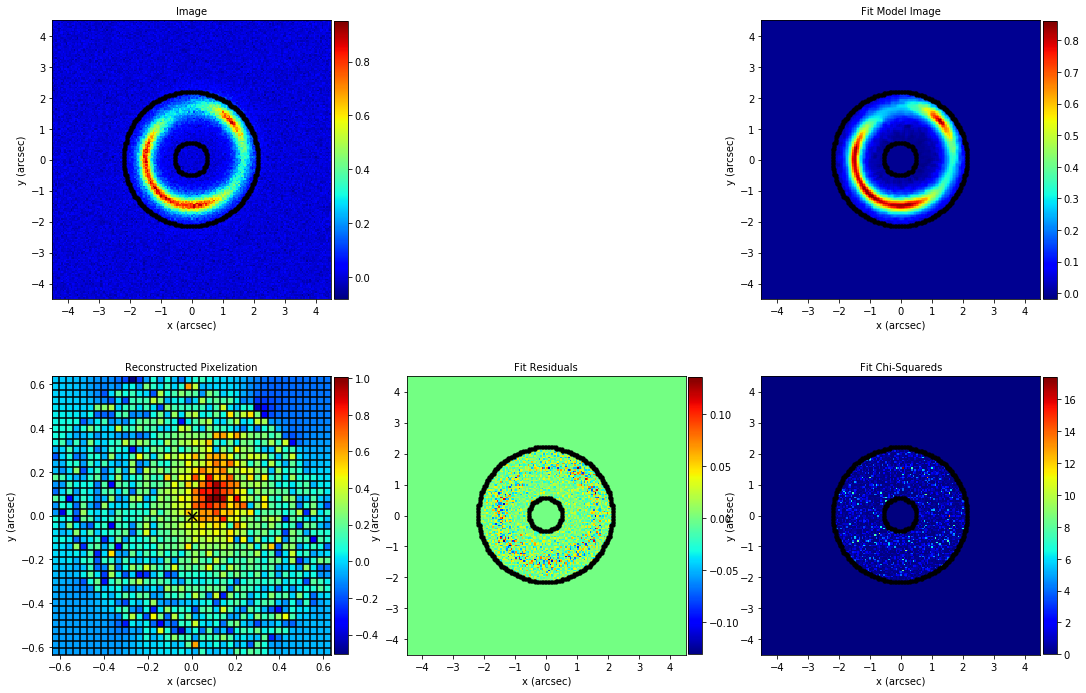

In [13]:
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)),
                         regularization=reg.Constant(coefficients=(1.0,)))
fit = perform_fit_with_source_galaxy(source_galaxy=source_galaxy)
print('Previous Bayesian Evidence:')
print(10395.370224426646)
print('New Bayesian Evidence:')
print(fit.evidence)
lens_fit_plotters.plot_fit_subplot(fit=fit, should_plot_mask=True, zoom_around_mask=True)

2) Can you think of any other ways we might increase the evidence even further? If not - don't worry about - but you'll learn that PyAutoLens actually adapts its source reconstructions to the properties of the image that it is fitting, so as to objectively maximize the evidence!